# fit_us_data.ipynb

Fit various functions to COVID-19 time series for U.S. counties using the Broyden–Fletcher–Goldfarb–Shanno solver from `sklearn.optimize`.

Inputs:
* `outputs/us_counties_clean.csv`: The contents of `data/us_counties.csv` after data cleaning by [clean_us_data.ipynb](./clean_us_data.ipynb)
* `outputs/us_counties_clean_meta.json`: Column type metadata for reading `data/us_counties_clean.csv` with `pd.read_csv()`

Outputs:
* `outputs/us_counties_curves.csv`: The curves that this notebook generated
* `outputs/us_counties_curves_meta.json`: Column type metadata for reading `data/us_counties_curves.csv` with `pd.read_csv()`
* `outputs/us_counties_curves_params.csv`: Model parameters corresponding to the curves in `data/us_counties_curves.csv`

**Note:** You can redirect these input and output files by setting the environment variable `COVID_OUTPUTS_DIR` to a replacement for the prefix `outputs` in the above paths.

In [1]:
# Initialization boilerplate
import os
import json
import pandas as pd
import numpy as np
import scipy.optimize
from sklearn import metrics
from typing import *

import text_extensions_for_pandas as tp

# Local file of utility functions
import util

# What precision of floating-point to use.
# Consider 32-bit if using GPU-accelerated solvers. Otherwise, 64-bit
# floating point is better because it reduces the chance of divergence.
fp_type = np.float64

# Allow environment variables to override data file locations.
_OUTPUTS_DIR = os.getenv("COVID_OUTPUTS_DIR", "outputs")
util.ensure_dir_exists(_OUTPUTS_DIR)  # create if necessary

# Load time series data

In [2]:
# Read in the CSV file and apply the saved type information
csv_file = os.path.join(_OUTPUTS_DIR, "us_counties_clean.csv")
meta_file = os.path.join(_OUTPUTS_DIR, "us_counties_clean_meta.json")

# Read column type metadata
with open(meta_file) as f:
    cases_meta = json.load(f)

# Pandas does not currently support parsing datetime64 from CSV files.
# As a workaround, read the "Date" column as objects and manually 
# convert after.
cases_meta["Date"] = "object"

cases_vertical = (
    pd
    .read_csv(csv_file, dtype=cases_meta, parse_dates=["Date"])   
    .set_index(["FIPS", "Date"], verify_integrity=True)
)
cases_vertical

State   County  Population  Confirmed  Deaths  Recovered  \
FIPS  Date                                                                     
1001  2020-01-22  Alabama  Autauga       55869          0       0          0   
      2020-01-23  Alabama  Autauga       55869          0       0          0   
      2020-01-24  Alabama  Autauga       55869          0       0          0   
      2020-01-25  Alabama  Autauga       55869          0       0          0   
      2020-01-26  Alabama  Autauga       55869          0       0          0   
...                   ...      ...         ...        ...     ...        ...   
56045 2020-09-12  Wyoming   Weston        6927         23       0          0   
      2020-09-13  Wyoming   Weston        6927         23       0          0   
      2020-09-14  Wyoming   Weston        6927         23       0          0   
      2020-09-15  Wyoming   Weston        6927         23       0          0   
      2020-09-16  Wyoming   Weston        6927         23       0          0   

                  Confirmed_Outlier  Deaths_Outlier  Recovered_Outlier  
FIPS  Date                                                              
1001  2020-01-22              False           False              False  
      2020-01-23              False           False              False  
      2020-01-24              False           False              False  
      2020-01-25              False           False              False  
      2020-01-26              False           False              False  
...                             ...             ...                ...  
56045 2020-09-12              False           False              False  
      2020-09-13              False           False              False  
      2020-09-14              False           False              False  
      2020-09-15              False           False              False  
      2020-09-16              False           False              False  

[750938 rows x 9 columns]

In [3]:
# As a workaround for a bug in Pandas' extension types system,
# we need to cast the boolean columns to ints.
for col in ["Confirmed_Outlier", "Deaths_Outlier", "Recovered_Outlier"]:
    cases_vertical[col] = cases_vertical[col].astype(np.int8)
cases_vertical

State   County  Population  Confirmed  Deaths  Recovered  \
FIPS  Date                                                                     
1001  2020-01-22  Alabama  Autauga       55869          0       0          0   
      2020-01-23  Alabama  Autauga       55869          0       0          0   
      2020-01-24  Alabama  Autauga       55869          0       0          0   
      2020-01-25  Alabama  Autauga       55869          0       0          0   
      2020-01-26  Alabama  Autauga       55869          0       0          0   
...                   ...      ...         ...        ...     ...        ...   
56045 2020-09-12  Wyoming   Weston        6927         23       0          0   
      2020-09-13  Wyoming   Weston        6927         23       0          0   
      2020-09-14  Wyoming   Weston        6927         23       0          0   
      2020-09-15  Wyoming   Weston        6927         23       0          0   
      2020-09-16  Wyoming   Weston        6927         23       0          0   

                  Confirmed_Outlier  Deaths_Outlier  Recovered_Outlier  
FIPS  Date                                                              
1001  2020-01-22                  0               0                  0  
      2020-01-23                  0               0                  0  
      2020-01-24                  0               0                  0  
      2020-01-25                  0               0                  0  
      2020-01-26                  0               0                  0  
...                             ...             ...                ...  
56045 2020-09-12                  0               0                  0  
      2020-09-13                  0               0                  0  
      2020-09-14                  0               0                  0  
      2020-09-15                  0               0                  0  
      2020-09-16                  0               0                  0  

[750938 rows x 9 columns]

## Collapse each time series down to a single cell

This kind of time series data is easier to manipulate at the macroscopic level if each time series occupies a 
single cell of the DataFrame. We use the [TensorArray](https://text-extensions-for-pandas.readthedocs.io/en/latest/#text_extensions_for_pandas.TensorArray) Pandas extension type from [Text Extensions for Pandas](https://github.com/CODAIT/text-extensions-for-pandas).

In [4]:
cases, dates = util.collapse_time_series(cases_vertical, [
    "Confirmed", "Deaths", "Recovered", 
    "Confirmed_Outlier", "Deaths_Outlier", "Recovered_Outlier"])
cases

,State,County,Population,Confirmed,Deaths,Recovered,Confirmed_Outlier,Deaths_Outlier,Recovered_Outlier
FIPS,,,,,,,,,
1001,Alabama,Autauga,55869,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1005,Alabama,Barbour,24686,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1007,Alabama,Bibb,22394,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1009,Alabama,Blount,57826,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
56039,Wyoming,Teton,23464,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
56041,Wyoming,Uinta,20226,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [5]:
# To simplify the code that follows, we only fit curves to one of
# the time series for each county. 
# Change the following constant to use a different time series:
ts_col_name = "Confirmed"

## Aliasing in time series for sparsely-populated counties

Because these time series are integer-valued, there can be problems with aliasing. 
Here are some examples of what aliasing looks like (The `graph_examples()` function is defined in [util.py](./util.py))

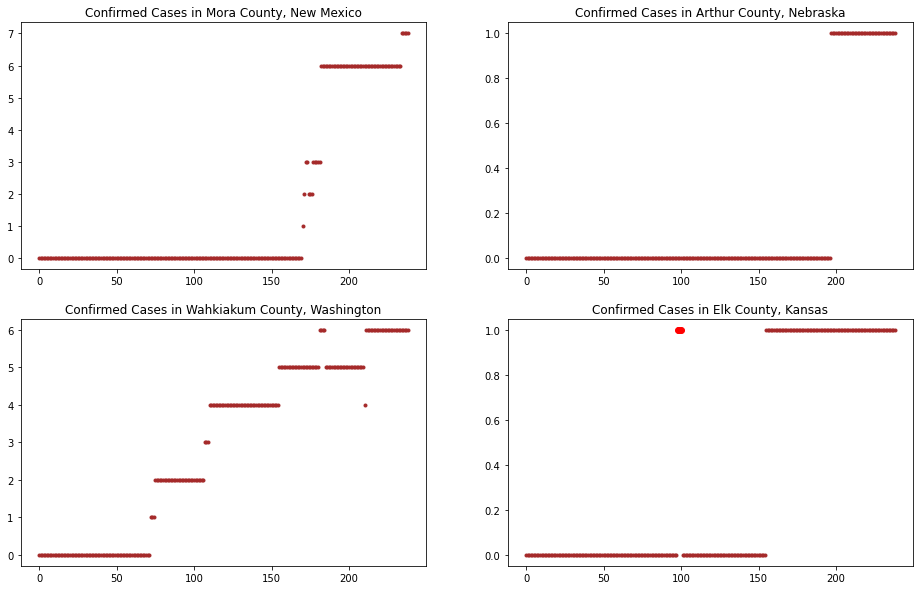

In [6]:
util.graph_examples(cases, ts_col_name, {}, 
                    mask=(np.max(cases[ts_col_name].array, axis=1) < 10))

## Filter time series that are subject to aliasing

To avoid problems due to aliasing, we will restrict the analysis
in the rest of this notebook to time series whose maximum values
go above a threshold.

In [7]:

alias_threshold = 100

# We also cut off the sections at the beginning of the time 
# series where every time series' value is below this threshold.

# Find what point in the time series at least one county went above
# the threshold.
first_time_above_min = np.argmax(np.max(cases[ts_col_name].array, axis=0) >= alias_threshold)
print(f"Dropping the first {first_time_above_min} elements of each time series.")

# Find which counties have at least one time series value above the 
# threshold.
counties_mask = np.max(cases[ts_col_name].array, axis=1) >= alias_threshold

# Filter rows
filtered = cases[counties_mask].copy(deep=True)

# Truncate time series to just the times when at least one county
# was above our threshold.
filtered[ts_col_name] = filtered[ts_col_name].array[:,first_time_above_min:]

# Also filter the outlier masks
outlier_col_name = ts_col_name + "_Outlier"
filtered[outlier_col_name] = filtered[outlier_col_name].array[:,first_time_above_min:]

filtered_dates = dates[first_time_above_min:]

# Drop time series columns other than the one we analyze
series_to_keep = [ts_col_name, outlier_col_name]
metadata_cols = []
to_drop = []
for colname in filtered.columns:
    if not isinstance(filtered[colname].dtype, tp.TensorType):
        metadata_cols.append(colname)
    elif colname not in series_to_keep:
        to_drop.append(colname)
        
filtered = filtered.drop(columns=to_drop)

filtered

Dropping the first 48 elements of each time series.


,State,County,Population,Confirmed,Confirmed_Outlier
FIPS,,,,,
1001,Alabama,Autauga,55869,[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...
1003,Alabama,Baldwin,223234,[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...
1005,Alabama,Barbour,24686,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...
1007,Alabama,Bibb,22394,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...
1009,Alabama,Blount,57826,[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...
...,...,...,...,...,...
56033,Wyoming,Sheridan,30485,[ 0. 0. 1. 1. 1. 1. 1. 2. 4. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...
56037,Wyoming,Sweetwater,42343,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...
56039,Wyoming,Teton,23464,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...


# Warm-up: Fit a straight line

We use sklearn's implementation of [BGFS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) as the optimizer.

In [8]:
# What precision of floating-point to use
# On a laptop, there's not much reason to use 32-bit.
fp_type = np.float64
series_values = filtered[ts_col_name].array.astype(fp_type)
series_len = series_values.shape[1]
x = np.linspace(0, series_len - 1, series_len, dtype=fp_type)

def linear_curve(m, b):
    return m * x + b

def linear_objective(var_values, y):
    m, b = var_values
    return np.sum((y - (linear_curve(m, b))) ** 2)

linear_initial_guess = (0.1, 1.0)
linear_bounds = ((0.0, 1000.0), (float(-series_len), float(series_len)))

linear = filtered[metadata_cols].copy()
linear["Result_Object"] = [
    scipy.optimize.minimize(
        linear_objective, linear_initial_guess,
        args=(ts), bounds=linear_bounds)
    for ts in series_values
]
linear["Slope"] = linear["Result_Object"].apply(lambda r: r.x[0])
linear["Intercept"] = linear["Result_Object"].apply(lambda r: r.x[1])

# Generate all the linear curves
M = linear["Slope"].values.reshape([-1, 1])
X = x.reshape([1, -1])
B = linear["Intercept"].values.reshape([-1, 1])
linear["Curve"] = tp.TensorArray(M * X + B)

# Compute coefficient of determination
linear["R^2"] = [
    metrics.r2_score(
        filtered.loc[fips][ts_col_name], linear.loc[fips]["Curve"]) 
        for fips in filtered.index]

linear

,State,County,Population,Result_Object,Slope,Intercept,Curve,R^2
FIPS,,,,,,,,
1001,Alabama,Autauga,55869,"{'fun': 4705068.546585577, 'jac': [0.0, 12524....",7.795386,-191.000000,[-191. -183.20461375 -175.40922751 -167...,0.904094
1003,Alabama,Baldwin,223234,"{'fun': 155995651.21704817, 'jac': [0.0, 96005...",19.449691,-191.000000,[-1.91000000e+02 -1.71550309e+02 -1.52100619e+0...,0.711637
1005,Alabama,Barbour,24686,"{'fun': 589351.9508404733, 'jac': [-0.38417056...",4.307371,-132.818072,[-132.81807248 -128.51070131 -124.20333014 -119...,0.948131
1007,Alabama,Bibb,22394,"{'fun': 855765.6806133062, 'jac': [-0.08149072...",3.336710,-124.024156,[-124.0241563 -120.687446 -117.3507357 -114...,0.883098
1009,Alabama,Blount,57826,"{'fun': 6042508.069082174, 'jac': [0.186264516...",5.729295,-191.000000,[-191. -185.2707047 -179.5414094 -173...,0.796496
...,...,...,...,...,...,...,...,...
56033,Wyoming,Sheridan,30485,"{'fun': 185313.34560314956, 'jac': [0.02910383...",0.781591,-29.476255,[-29.47625479 -28.69466395 -27.91307312 -27.131...,0.656838
56037,Wyoming,Sweetwater,42343,"{'fun': 349193.03573851124, 'jac': [-1.5133991...",1.965681,-76.477959,[-7.64779586e+01 -7.45122776e+01 -7.25465966e+0...,0.865318
56039,Wyoming,Teton,23464,"{'fun': 554307.7267582945, 'jac': [0.745058064...",2.501266,-59.704009,[-5.97040087e+01 -5.72027424e+01 -5.47014760e+0...,0.867612


## Graph: Example linear curves

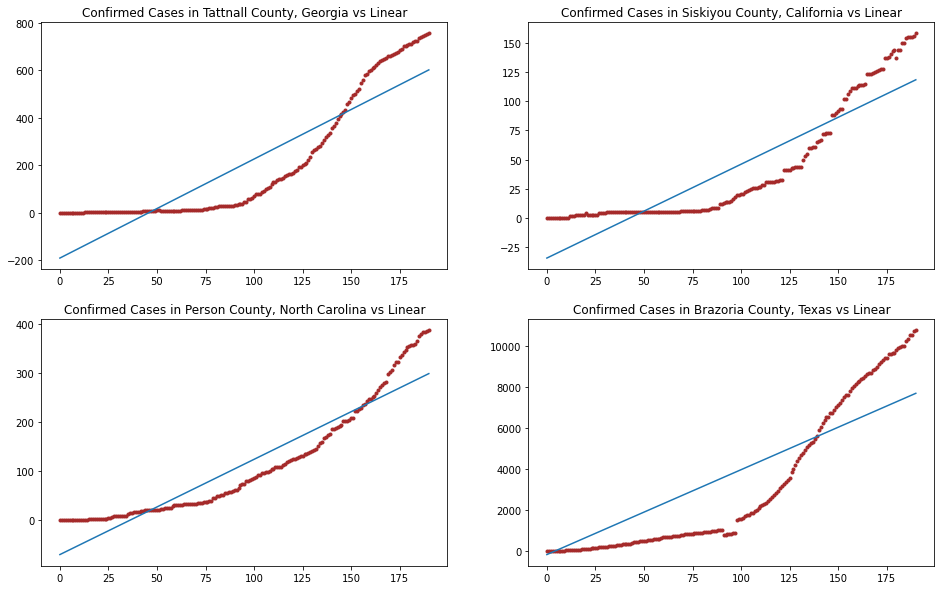

In [9]:
# Plot the lines we just fit, using the graph_examples() function in util.py.
util.graph_examples(filtered, ts_col_name, {"Linear": linear})

# Define code for fitting any curve

As you can see from the above graphs, straight lines do not explain the data in most of these time series.
Let's fit some more appropriate curves to this data, using the same BGFS optimizer.
First, we'll break out the repetitive parts of the curve-fitting process into a Python function.

In [10]:
def curve_fit_df(df: pd.DataFrame, ts_col_name: str,
                 curve_fn,
                 param_names: Tuple,
                 initial_guess: Tuple,
                 bounds: Tuple,     
                 regularize_fn = None):
    """
    Fit a curve to a column full of time series.
    
    :param df: DataFrame containing one time series per cell
    :param ts_col_name: Column containing the time series to analyze
    :param curve_fn: Function that, if called with a vector of X values
     and a tuple of parameters, will compute the value of the curve 
     being fit.
     If parameters are vectors, this function must compute multiple
     curves, one for each element of the vectors.
    
    :param param_names: Names of the parameters of `curve_fn`.
    :param initial_guess: Initial values for the paramters to start
     off the solver.
    :param bounds: Lower and upper bounds for the parameters.
    :param regularize_fn: Optional function that returns a 
     regularization penalty, given a set of parameter values.
    
    :returns: A dataframe with one row per row of `df`, containing
     information about the 
    """
    series_values = df[ts_col_name].array.astype(fp_type)
    series_len = series_values.shape[1]
    x = np.linspace(0, series_len - 1, series_len, dtype=fp_type)
    
    def return_zero(var_values):
        return 0.0
    
    if regularize_fn is None:
        regularize_fn = return_zero
    
    def objective(var_values, y):
        squared_diffs = np.sum((y - (curve_fn(x, var_values))) ** 2)
        return squared_diffs + regularize_fn(var_values)
    
    result = pd.DataFrame(index=df.index)
    result[metadata_cols] = df[metadata_cols]
    result["Result_Object"] = [
        scipy.optimize.minimize(
            objective, initial_guess,
            args=(ts), bounds=bounds)
        for ts in series_values
    ]
    
    # Add a column for each parameter
    for i in range(len(param_names)):
        name = param_names[i]
        result[name] = result["Result_Object"].apply(lambda r: r.x[i])

    # Generate all the curves
    param_vectors = [
        result[name].values.reshape([-1, 1])
        for name in param_names
    ]
    result["Curve"] = tp.TensorArray(curve_fn(x, param_vectors))

    # Compute coefficient of determination
    result["R^2"] = [
        metrics.r2_score(
            df.loc[fips][ts_col_name], result.loc[fips]["Curve"]) 
            for fips in df.index]

    return result

In [11]:
# Define curve-fitting routines using the function from the previous
# cell.

def fit_exponential(ts_col_name: str):
    """
    Fit an exponential curve to each time series in the specified column
    of the `cases` dataframe.
    """    
    def curve_fn(x, var_values):
        rate, offset = var_values
        # Y = e^(rate * (X - offset))
        return np.exp(rate * (x - offset))
    
    param_names = ("Rate", "Offset")
    initial_guess = (0.1, 1.0)
    bounds = ((0.001, 1.0), (0.0, float(len(filtered_dates))))
    
    return curve_fit_df(filtered, ts_col_name, curve_fn,
                        param_names, initial_guess, bounds)


def fit_logistic(ts_col_name: str):
    """
    Fit a logistic curve to each time series in the specified column
    of the `cases` dataframe.
    """    
    def curve_fn(x, var_values):
        max_, rate, offset = var_values
        # Y = max / (1 + e^(-rate *(X - offset))
        return max_ / (1.0 + np.exp(-rate * (x - offset)))
    
    param_names = ("Max", "Rate", "Offset")
    initial_guess = (1000.0, 0.1, 1.0)
    bounds = ((0.0, 1e6), (0.0, 1.0), (0.0, float(len(filtered_dates))))
    
    return curve_fit_df(filtered, ts_col_name, curve_fn,
                        param_names, initial_guess, bounds)


def fit_logistic2(ts_col_name: str):
    """
    Fit a mixture of two logistic curves to each time series in the 
    specified column of the `cases` dataframe.
    """
    # Distance from X=0 at which the logistic function is close enough to 0 or 1
    # that we can consider it to have "triggered"
    logistic2_limit = np.array(6., dtype=fp_type)
    
    def curve_fn(x, var_values):
        (max1, rate1, offset1, 
         max2, rate2, offset2, 
         switch_begin, switch_end) = var_values
        
        # logistic curve is Y = max / (1 + e^(-rate *(X - offset))
        logistic1 = max1 / (1.0 + np.exp(-rate1 * (x - offset1)))
        logistic2 = max2 / (1.0 + np.exp(-rate2 * (x - offset2)))

        # What fraction of the output comes from logistic2?
        def sigmoid(x_):
            return 1. / (1. + np.exp(-x_))
        
        mix_input = (x - switch_begin - logistic2_limit) / np.maximum(1.0, (switch_end - switch_begin))
        return logistic1 * (1.0 - sigmoid(mix_input)) + logistic2 * sigmoid(mix_input)
    
    def regularize_fn(var_values):
        (max1, rate1, offset1, 
         max2, rate2, offset2, 
         switch_begin, switch_end) = var_values
        reg_coeff = 1e7
        linear_terms = [
            max(0.0, switch_begin - switch_end - 1.0)  # switch_end >= switch_begin + 1
        ]
        return reg_coeff * sum([t for t in linear_terms])
    
    param_names = (
        "Max1", "Rate1", "Offset1",
        "Max2", "Rate2", "Offset2",
        "Switch_Begin", "Switch_End")
    initial_guess = (
        1000.0, 0.1, 1.0,  # First logistic function
        1000.0, 0.1, 1.0,  # Second logistic function
        10.0, 20.0  # Switchover
    )
    series_len = len(filtered_dates)
    bounds = (
        (0.0, 1e6), (0.0, 10.0), (0.0, float(series_len)),   # First logistic function
        (0.0, 1e6), (0.0, 10.0), (0.0, float(series_len)),   # Second logistic function
        (0.0, float(series_len)), (0.0, float(series_len))  # Switchover
    )
    
    return curve_fit_df(filtered, ts_col_name, curve_fn,
                        param_names, initial_guess, bounds,
                        regularize_fn=regularize_fn)


# Fit exponential curves

In [12]:
exp_df = fit_exponential(ts_col_name)
exp_df

,State,County,Population,Result_Object,Rate,Offset,Curve,R^2
FIPS,,,,,,,,
1001,Alabama,Autauga,55869,"{'fun': 24557609.886675283, 'jac': [2.60770320...",0.040839,0.0,[1.00000000e+00 1.04168475e+00 1.08510712e+00 1...,0.499430
1003,Alabama,Baldwin,223234,"{'fun': 207558479.0073038, 'jac': [-473.856925...",0.047136,0.0,[1.00000000e+00 1.04826447e+00 1.09885840e+00 1...,0.616322
1005,Alabama,Barbour,24686,"{'fun': 7475482.42162516, 'jac': [-0.745058059...",0.036827,0.0,[1.00000000e+00 1.03751304e+00 1.07643331e+00 1...,0.342076
1007,Alabama,Bibb,22394,"{'fun': 2176928.2979482906, 'jac': [-5.2619725...",0.035741,0.0,[ 1. 1.0363871 1.07409823 1.113...,0.702622
1009,Alabama,Blount,57826,"{'fun': 6767008.183567378, 'jac': [1.024454831...",0.039372,0.0,[1.00000000e+00 1.04015703e+00 1.08192664e+00 1...,0.772095
...,...,...,...,...,...,...,...,...
56033,Wyoming,Sheridan,30485,"{'fun': 8757.809039078365, 'jac': [-0.12150849...",0.028504,0.0,[ 1. 1.02891386 1.05866373 1.089...,0.983782
56037,Wyoming,Sweetwater,42343,"{'fun': 759935.6401222668, 'jac': [1607.881858...",0.032651,0.0,[ 1. 1.03318945 1.06748045 1.102...,0.706897
56039,Wyoming,Teton,23464,"{'fun': 1919320.6156899096, 'jac': [2893.87535...",0.034618,0.0,[ 1. 1.0352243 1.07168935 1.109...,0.541599


## Graph: Example exponential curves

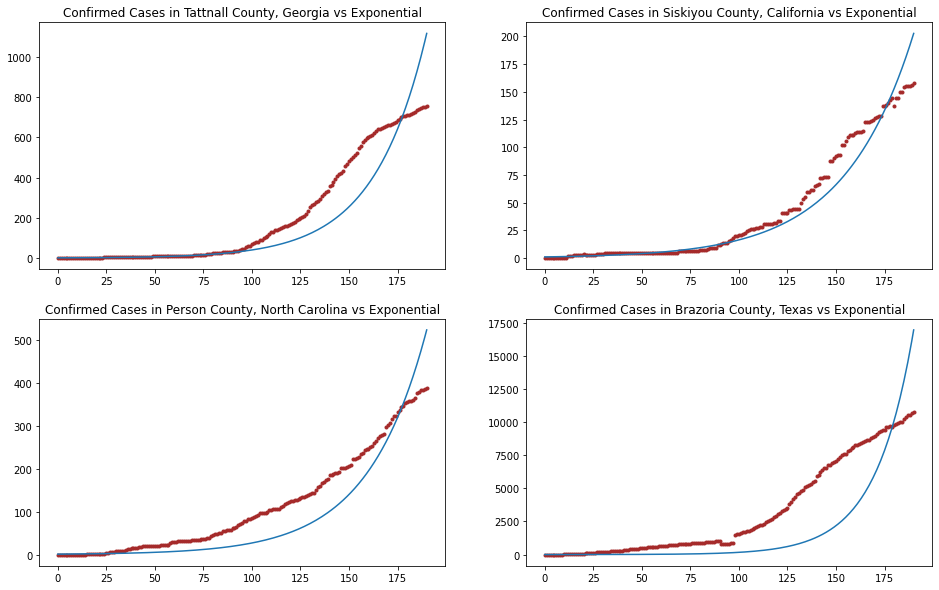

In [13]:
util.graph_examples(filtered, ts_col_name, {"Exponential": exp_df})

# Fit logistic curves

The [logistic function](https://en.wikipedia.org/wiki/Logistic_function) produces an "S"-shaped curve 
that often closely matches one wave of a disease outbreak.

In [14]:
log_df = fit_logistic(ts_col_name)
log_df

,State,County,Population,Result_Object,Max,Rate,Offset,Curve,R^2
FIPS,,,,,,,,,
1001,Alabama,Autauga,55869,"{'fun': 96542.94325742962, 'jac': [-0.01309686...",1590.052584,0.039488,129.980760,[ 9.3277625 9.70117131 10.08943301 10...,0.998032
1003,Alabama,Baldwin,223234,"{'fun': 2817870.9229061045, 'jac': [0.0, -840....",4865.445687,0.065441,137.479038,[6.02295894e-01 6.43023771e-01 6.86505321e-01 7...,0.994791
1005,Alabama,Barbour,24686,"{'fun': 77567.70257697643, 'jac': [-0.00291038...",679.404448,0.043202,112.873994,[ 5.14106278 5.36624076 5.60119958 5.846...,0.993173
1007,Alabama,Bibb,22394,"{'fun': 20092.89480104382, 'jac': [0.001091392...",709.823846,0.036820,143.160423,[ 3.62817231 3.76352987 3.90390935 4.049...,0.997255
1009,Alabama,Blount,57826,"{'fun': 283973.43108994246, 'jac': [-0.0116416...",1296.922046,0.049456,144.181304,[1.03695886e+00 1.08948804e+00 1.14467585e+00 1...,0.990436
...,...,...,...,...,...,...,...,...,...
56033,Wyoming,Sheridan,30485,"{'fun': 13955.517632369227, 'jac': [-0.0001818...",429.482835,0.038231,191.000000,[ 0.28931852 0.30058574 0.31229143 0.324...,0.974157
56037,Wyoming,Sweetwater,42343,"{'fun': 10226.458781005618, 'jac': [0.0, -0.36...",327.110747,0.056835,128.058818,[2.25690612e-01 2.38879574e-01 2.52838680e-01 2...,0.996056
56039,Wyoming,Teton,23464,"{'fun': 181732.16073097504, 'jac': [-0.0029103...",880.215103,0.022177,175.891796,[ 17.45121528 17.83462298 18.22627629 18.626...,0.956596


## Graph: Example logistic curves

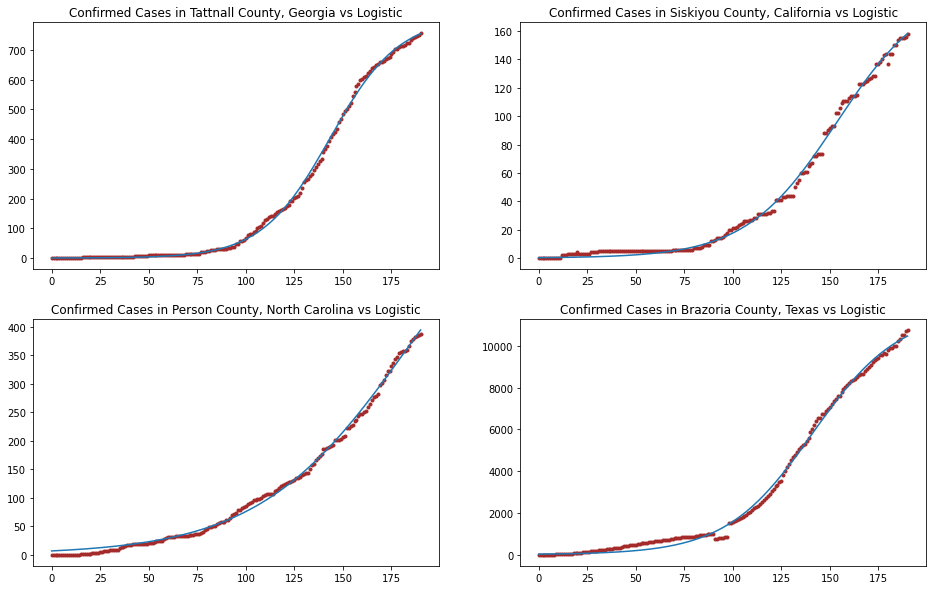

In [15]:
util.graph_examples(filtered, ts_col_name, {"Logistic": log_df})

# Fit a mixture of two logistic curves

A mixture of two logistic curves with different starting points can explain the data for disease
outbreaks involving two distinct waves.

In [16]:
log2_df = fit_logistic2(ts_col_name)
log2_df

/Users/freiss/pd/cn-demo2/env/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in exp


/Users/freiss/pd/cn-demo2/env/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in exp


,State,County,Population,Result_Object,Max1,Rate1,Offset1,Max2,Rate2,Offset2,Switch_Begin,Switch_End,Curve,R^2
FIPS,,,,,,,,,,,,,,
1001,Alabama,Autauga,55869,"{'fun': 71580.88555861692, 'jac': [2.268667576...",1522.318450,0.070265,96.234191,1601.552878,0.042286,134.537067,4.375111,58.299737,[ 3.4049623 3.59732569 3.80027857 4...,0.998541
1003,Alabama,Baldwin,223234,"{'fun': 1004648.3714000334, 'jac': [-0.2793965...",513.462631,0.132519,40.848802,6317.543710,0.081696,135.330599,5.131853,190.999465,[1.22173540e+00 1.38792754e+00 1.57669631e+00 1...,0.998143
1005,Alabama,Barbour,24686,"{'fun': 34648.189682494805, 'jac': [0.00072759...",561.814750,10.000000,188.706987,921.779486,0.046162,105.029521,0.000000,191.000000,[ 3.52948132 3.70469473 3.88851264 4.081...,0.996951
1007,Alabama,Bibb,22394,"{'fun': 20006.532745378227, 'jac': [-0.1808074...",680.624634,0.041359,143.316933,711.522237,0.036683,143.316788,10.000067,19.999944,[ 2.12465443 2.2390666 2.36069772 2.489...,0.997267
1009,Alabama,Blount,57826,"{'fun': 283988.41507911944, 'jac': [0.0, 0.0, ...",5544.370981,6.230106,144.279760,1296.999375,0.049451,144.184437,13.405221,14.708308,[3.53733969e-07 8.00601326e-07 1.81198565e-06 4...,0.990436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56033,Wyoming,Sheridan,30485,"{'fun': 14525.998284375988, 'jac': [-0.0018189...",389.992919,0.072505,190.766195,417.468423,0.036838,190.764386,10.000090,19.999942,[6.24801328e-02 7.03740355e-02 7.91485934e-02 8...,0.973101
56037,Wyoming,Sweetwater,42343,"{'fun': 10767.740375048232, 'jac': [0.0, -0.0,...",315.482281,10.000000,191.000000,327.288391,0.056624,127.891841,6.524029,28.075875,[8.40025340e-02 9.15547776e-02 9.97357344e-02 1...,0.995847
56039,Wyoming,Teton,23464,"{'fun': 173383.00779780955, 'jac': [0.0, -47.2...",936.112794,0.036106,187.689296,1001.390593,0.020630,187.801803,13.652528,15.393658,[ 1.06613482 1.10547347 1.14640675 1.189...,0.958590


## Graph: Examples of logistic curve mixtures

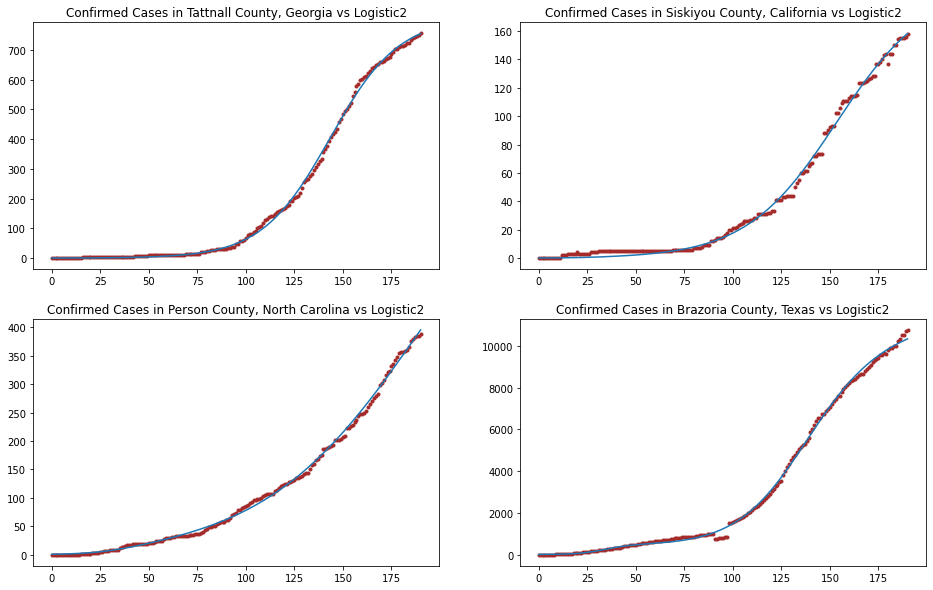

In [17]:
util.graph_examples(filtered, ts_col_name, {"Logistic2": log2_df})

# Save the curves

Save the coefficients of the curves we just fit to disk, so that [`analyze_fit_us_data.ipynb`](analyze_fit_us_data.ipynb)
can reconstruct the curves and compare them to the underlying time series.

In [18]:
# Stuff all the curves that we have fit into a single dataframe,
# along with the original series' values
curves_df = filtered[metadata_cols + [ts_col_name, outlier_col_name]].copy()
curves_df["Exponential"] = exp_df["Curve"]
curves_df["Logistic"] = log_df["Curve"]
curves_df["Logistic2"] = log2_df["Curve"]
curves_df

,State,County,Population,Confirmed,Confirmed_Outlier,Exponential,Logistic,Logistic2
FIPS,,,,,,,,
1001,Alabama,Autauga,55869,[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...,[1.00000000e+00 1.04168475e+00 1.08510712e+00 1...,[ 9.3277625 9.70117131 10.08943301 10...,[ 3.4049623 3.59732569 3.80027857 4...
1003,Alabama,Baldwin,223234,[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...,[1.00000000e+00 1.04826447e+00 1.09885840e+00 1...,[6.02295894e-01 6.43023771e-01 6.86505321e-01 7...,[1.22173540e+00 1.38792754e+00 1.57669631e+00 1...
1005,Alabama,Barbour,24686,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...,[1.00000000e+00 1.03751304e+00 1.07643331e+00 1...,[ 5.14106278 5.36624076 5.60119958 5.846...,[ 3.52948132 3.70469473 3.88851264 4.081...
1007,Alabama,Bibb,22394,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...,[ 1. 1.0363871 1.07409823 1.113...,[ 3.62817231 3.76352987 3.90390935 4.049...,[ 2.12465443 2.2390666 2.36069772 2.489...
1009,Alabama,Blount,57826,[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...,[1.00000000e+00 1.04015703e+00 1.08192664e+00 1...,[1.03695886e+00 1.08948804e+00 1.14467585e+00 1...,[3.53733969e-07 8.00601326e-07 1.81198565e-06 4...
...,...,...,...,...,...,...,...,...
56033,Wyoming,Sheridan,30485,[ 0. 0. 1. 1. 1. 1. 1. 2. 4. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...,[ 1. 1.02891386 1.05866373 1.089...,[ 0.28931852 0.30058574 0.31229143 0.324...,[6.24801328e-02 7.03740355e-02 7.91485934e-02 8...
56037,Wyoming,Sweetwater,42343,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...,[ 1. 1.03318945 1.06748045 1.102...,[2.25690612e-01 2.38879574e-01 2.52838680e-01 2...,[8.40025340e-02 9.15547776e-02 9.97357344e-02 1...
56039,Wyoming,Teton,23464,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...,[ 1. 1.0352243 1.07168935 1.109...,[ 17.45121528 17.83462298 18.22627629 18.626...,[ 1.06613482 1.10547347 1.14640675 1.189...


In [19]:
# Expand out the tensors to multiple rows for writing to a CSV file, and
# cast the boolean values back to np.bool
curves_vertical = util.explode_time_series(curves_df, filtered_dates)
curves_vertical["Confirmed_Outlier"] = curves_vertical["Confirmed_Outlier"].astype(np.bool)
curves_vertical

State    County  Population  Confirmed  Confirmed_Outlier  \
FIPS  Date                                                                      
1001  2020-03-10  Alabama   Autauga       55869        0.0              False   
      2020-03-11  Alabama   Autauga       55869        0.0              False   
      2020-03-12  Alabama   Autauga       55869        0.0              False   
      2020-03-13  Alabama   Autauga       55869        0.0              False   
      2020-03-14  Alabama   Autauga       55869        0.0              False   
...                   ...       ...         ...        ...                ...   
56043 2020-09-12  Wyoming  Washakie        7805      111.0              False   
      2020-09-13  Wyoming  Washakie        7805      111.0              False   
      2020-09-14  Wyoming  Washakie        7805      111.0              False   
      2020-09-15  Wyoming  Washakie        7805      111.0              False   
      2020-09-16  Wyoming  Washakie        7805      111.0              False   

                  Exponential    Logistic   Logistic2  
FIPS  Date                                             
1001  2020-03-10     1.000000    9.327762    3.404962  
      2020-03-11     1.041685    9.701171    3.597326  
      2020-03-12     1.085107   10.089433    3.800279  
      2020-03-13     1.130340   10.493131    4.014386  
      2020-03-14     1.177457   10.912869    4.240243  
...                       ...         ...         ...  
56043 2020-09-12   142.736615  118.473003  117.717763  
      2020-09-13   146.594919  119.808891  119.028758  
      2020-09-14   150.557516  121.145390  120.340921  
      2020-09-15   154.627226  122.482182  121.653961  
      2020-09-16   158.806944  123.818947  122.967585  

[457254 rows x 8 columns]

In [20]:
# Write out the results to a CSV file plus a JSON file of type metadata.
counties_curves_csv_data_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves.csv")
curves_vertical.to_csv(counties_curves_csv_data_file, index=True)
col_type_mapping = {
    key: str(value) for key, value in curves_vertical.dtypes.iteritems()
}

counties_curves_json_data_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves_meta.json")
print(f"Writing curves to {counties_curves_json_data_file}")
with open(counties_curves_json_data_file, "w") as f:
    json.dump(col_type_mapping, f)

Writing curves to outputs/us_counties_curves_meta.json


In [21]:
# Combine all of the parameters of the curve into another dataframe and
# write that dataframe to a second CSV file.
params = filtered[metadata_cols].copy()
params["Exp_Rate"] = exp_df["Rate"]
params["Exp_Offset"] = exp_df["Offset"]

params["Log_Max"] = log_df["Max"]
params["Log_Rate"] = log_df["Rate"]
params["Log_Offset"] = log_df["Offset"]

params["Log2_Max1"] = log2_df["Max1"]
params["Log2_Rate1"] = log2_df["Rate1"]
params["Log2_Offset1"] = log2_df["Offset1"]
params["Log2_Max2"] = log2_df["Max2"]
params["Log2_Rate2"] = log2_df["Rate2"]
params["Log2_Offset2"] = log2_df["Offset2"]
params["Log2_Switch_Begin"] = log2_df["Switch_Begin"]
params["Log2_Switch_End"] = log2_df["Switch_End"]
params

,State,County,Population,Exp_Rate,Exp_Offset,Log_Max,Log_Rate,Log_Offset,Log2_Max1,Log2_Rate1,Log2_Offset1,Log2_Max2,Log2_Rate2,Log2_Offset2,Log2_Switch_Begin,Log2_Switch_End
FIPS,,,,,,,,,,,,,,,,
1001,Alabama,Autauga,55869,0.040839,0.0,1590.052584,0.039488,129.980760,1522.318450,0.070265,96.234191,1601.552878,0.042286,134.537067,4.375111,58.299737
1003,Alabama,Baldwin,223234,0.047136,0.0,4865.445687,0.065441,137.479038,513.462631,0.132519,40.848802,6317.543710,0.081696,135.330599,5.131853,190.999465
1005,Alabama,Barbour,24686,0.036827,0.0,679.404448,0.043202,112.873994,561.814750,10.000000,188.706987,921.779486,0.046162,105.029521,0.000000,191.000000
1007,Alabama,Bibb,22394,0.035741,0.0,709.823846,0.036820,143.160423,680.624634,0.041359,143.316933,711.522237,0.036683,143.316788,10.000067,19.999944
1009,Alabama,Blount,57826,0.039372,0.0,1296.922046,0.049456,144.181304,5544.370981,6.230106,144.279760,1296.999375,0.049451,144.184437,13.405221,14.708308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56033,Wyoming,Sheridan,30485,0.028504,0.0,429.482835,0.038231,191.000000,389.992919,0.072505,190.766195,417.468423,0.036838,190.764386,10.000090,19.999942
56037,Wyoming,Sweetwater,42343,0.032651,0.0,327.110747,0.056835,128.058818,315.482281,10.000000,191.000000,327.288391,0.056624,127.891841,6.524029,28.075875
56039,Wyoming,Teton,23464,0.034618,0.0,880.215103,0.022177,175.891796,936.112794,0.036106,187.689296,1001.390593,0.020630,187.801803,13.652528,15.393658


In [22]:
counties_curves_params_csv_data_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves_params.csv")
print(f"Writing parameters of curves to {counties_curves_params_csv_data_file}.")
params.to_csv(counties_curves_params_csv_data_file, index=True)

Writing parameters of curves to outputs/us_counties_curves_params.csv.
